### What are the estimated wildfire smoke impacts on Birmingham, AL each year for the most recent 60 years of wildfire data? 


In [60]:
import json
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


### Reading and formatting Wildfire Data

In [2]:
with open("raw-data/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json", "r") as f:
    data = json.load(f)

In [11]:
# Set up logging
logging.basicConfig(filename='geo_processing.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Extract features (geometry and attributes)
features = data.get('features', [])

# Prepare lists to store geometries and attributes
geometries = []
attributes = []

# Use tqdm for a progress bar
for feature in tqdm(features, desc="Processing features"):
    try:
        geometry = feature.get('geometry', {})
        if 'rings' in geometry:
            rings = geometry['rings']
            if rings:
                polygon = Polygon(rings[0])
                geometries.append(polygon)
            else:
                logging.warning(f"Empty rings found in feature: {feature.get('attributes', {}).get('OBJECTID', 'Unknown')}")
                geometries.append(None)
        else:
            logging.warning(f"No 'rings' found in feature: {feature.get('attributes', {}).get('OBJECTID', 'Unknown')}")
            geometries.append(None)

        attributes.append(feature.get('attributes', {}))

    except Exception as e:
        logging.error(f"Error processing feature: {feature.get('attributes', {}).get('OBJECTID', 'Unknown')}. Error: {str(e)}")
        geometries.append(None)
        attributes.append({})

# Convert attributes to a DataFrame
df_attributes = pd.DataFrame(attributes)

# Create a GeoDataFrame using geometries and attributes
gdf = gpd.GeoDataFrame(df_attributes, geometry=geometries, crs="ESRI:102008")

# Log successful completion
logging.info("GeoDataFrame creation complete. Total features processed: {}".format(len(gdf)))


Processing features: 100%|██████████| 135061/135061 [00:43<00:00, 3076.40it/s]


In [12]:
gdf.head()

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Wildfire_Notice,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,geometry
0,1,1,Wildfire,1860,1,1 (1),3940.207089,1594.545237,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.047590,NaN,No,64888.449849,1.594545e+07,"POLYGON ((-1883775.596 1194154.192, -1883782.4..."
1,2,2,Wildfire,1860,1,1 (1),772.518249,312.627044,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.071367,NaN,No,23462.288613,3.126270e+06,"POLYGON ((-1887470.131 1187759.244, -1887546.2..."
2,3,3,Wildfire,1860,1,1 (1),333.020409,134.768578,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.379578,NaN,No,6679.573569,1.347686e+06,"POLYGON ((-1889386.119 1190683.928, -1889454.1..."
3,4,4,Wildfire,1870,1,"1 (1), 3 (1)",22294.993577,9022.463795,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.158038,NaN,No,84700.719226,9.022464e+07,"POLYGON ((-1428896.297 864980.034, -1428690.21..."
4,5,5,Wildfire,1870,1,"1 (1), 3 (1)",36.985574,14.967531,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.218009,NaN,No,2937.265383,1.496753e+05,"POLYGON ((-1371410.414 595942.396, -1371424.53..."


In [13]:
print(gdf.crs)

ESRI:102008


In [15]:
import geopandas as gpd
from shapely.geometry import Point

# Assuming `gdf` is the GeoDataFrame with the fire data and CRS is already set correctly.

# Define the latitude and longitude of your city (e.g., Birmingham, AL)
city_lat = 33.53
city_lon = -86.80

# Create a Point geometry for the city
city_point = gpd.GeoSeries([Point(city_lon, city_lat)], crs="EPSG:4326")


# Convert the GeoDataFrame to a projected CRS where distances are in meters
# We use an appropriate projection for the United States that preserves distances
gdf_projected = gdf.to_crs(epsg=3395)  # EPSG:3395 is World Mercator, distances in meters
city_point_projected = city_point.to_crs(epsg=3395) 

# Step 4: Calculate distances from each fire to the city
# The distance is in meters, so we convert 1800 miles to meters (1 mile = 1609.34 meters)
distance_threshold_meters = 1800 * 1609.34

# Calculate the distance from each fire to the city
gdf_projected['distance_to_city'] = gdf_projected.geometry.distance(city_point_projected.iloc[0])

# Step 5: Filter out fires beyond 1800 miles
gdf_within_distance = gdf_projected[gdf_projected['distance_to_city'] <= distance_threshold_meters]

# Step 6: Filter out rows where Overlap_Within_1_or_2_Flag is not None
gdf_filtered = gdf_within_distance[gdf_within_distance['Overlap_Within_1_or_2_Flag'].isnull()]

# Check the filtered GeoDataFrame
print(gdf_filtered.head())


    OBJECTID  USGS_Assigned_ID Assigned_Fire_Type  Fire_Year  \
8          9                 9           Wildfire       1880   
9         10                10           Wildfire       1880   
10        11                11           Wildfire       1880   
11        12                12           Wildfire       1880   
12        13                13           Wildfire       1880   

    Fire_Polygon_Tier Fire_Attribute_Tiers     GIS_Acres  GIS_Hectares  \
8                   1         1 (1), 3 (1)  14946.172721   6048.501507   
9                   1         1 (1), 3 (1)   3115.787359   1260.914408   
10                  1         1 (1), 3 (1)   1327.574260    537.250242   
11                  1         1 (1), 3 (1)    455.900592    184.496424   
12                  1         1 (1), 3 (1)    272.138268    110.130450   

                                      Source_Datasets Listed_Fire_Types  ...  \
8   Comb_National_NIFC_Interagency_Fire_Perimeter_...      Wildfire (2)  ...   
9   Comb_N

In [21]:
gdf_filtered.shape
gdf_filtered.to_file("intermediate-data/gdf_filtered.geojson", driver="GeoJSON")

In [22]:
analysis_distance = 650 * 1609.34
gdf_analysis = gdf_filtered[gdf_filtered['distance_to_city'] <= analysis_distance]
print(gdf_analysis.shape)
gdf_analysis.to_file("intermediate-data/gdf_analysis.geojson", driver= "GeoJSON")

(19134, 32)


### Creating a smoke estimate

In [45]:
gdf_analysis = gpd.read_file("intermediate-data/gdf_analysis.geojson")

In [46]:
# Define the weighting factor for each fire type 

fire_type_weights = {
    'Wildfire': 1.0,            # Baseline for wildfire
    'Prescribed Burn': 0.6,     # Assume prescribed burns produce less smoke
    'Other': 0.7                # Catch-all for other types
}

# Add the fire type weighting factor 
gdf_analysis.loc[:, 'fire_type_weight'] = gdf_analysis['Assigned_Fire_Type'].map(fire_type_weights).fillna(0.7)

# Ensure the distance is not zero and convert the distance to kilometers
gdf_analysis['distance_to_city_km'] = gdf_analysis['distance_to_city'] / 1000  # Convert meters to kilometers
gdf_analysis.loc[gdf_analysis['distance_to_city_km'] == 0, 'distance_to_city_km'] = 1e-5  # Replace zero distances

# Calculate the index for each fire using the formula: (GIS_Hectares * fire_type_weight) / distance_to_city_km^2
gdf_analysis['index_value'] = (gdf_analysis['GIS_Hectares'] * gdf_analysis['fire_type_weight']) / (gdf_analysis['distance_to_city_km'] ** 2)

# Group by 'Fire_Year' to sum the index for each year
yearly_index = gdf_analysis.groupby('Fire_Year')['index_value'].sum().reset_index()

# Rename the column for clarity
yearly_index.rename(columns={'index_value': 'yearly_smoke_index'}, inplace=True)

# Display the yearly index
print(yearly_index)

    Fire_Year  yearly_smoke_index
0        1920            0.000958
1        1921            0.000009
2        1923            0.001438
3        1925            0.039641
4        1926            0.000164
..        ...                 ...
91       2016            1.877045
92       2017            0.978377
93       2018            0.984609
94       2019            1.980190
95       2020            0.923078

[96 rows x 2 columns]


In [5]:
# Find the index of the minimum yearly smoke index
min_index = yearly_index['yearly_smoke_index'].idxmin()

# Retrieve the corresponding year
min_year = yearly_index.loc[min_index, 'Fire_Year']

# Print the year and the minimum smoke index
min_value = yearly_index.loc[min_index, 'yearly_smoke_index']
print(f"The year with the minimum smoke index is {min_year} with a smoke index of {min_value}.")


The year with the minimum smoke index is 1921 with a smoke index of 8.822010532826745e-06.


In [6]:
# Find the index of the maximum yearly smoke index
max_index = yearly_index['yearly_smoke_index'].idxmax()

# Retrieve the corresponding year
max_year = yearly_index.loc[max_index, 'Fire_Year']

# Print the year and the maximum smoke index
max_value = yearly_index.loc[max_index, 'yearly_smoke_index']
print(f"The year with the maximum smoke index is {max_year} with a smoke index of {max_value}.")

The year with the maximum smoke index is 2011 with a smoke index of 2.3041231365929202.


### Comparing to AQI


In [47]:
yearly_index_for_aqi = yearly_index.copy()

In [48]:
# Load and clean the AQI data
# Specify the columns you want to keep
columns_to_keep = ['date_local','parameter','aqi']

# Load the CSV files, keeping only the relevant columns
gaseous_aqi = pd.read_csv('intermediate-data/gaseous_aqi_data.csv', usecols=columns_to_keep)
particulate_aqi = pd.read_csv('intermediate-data/particulate_aqi_data.csv', usecols=columns_to_keep)

# Append both AQI datasets into a single DataFrame
aqi_data = pd.concat([gaseous_aqi, particulate_aqi])


In [49]:
aqi_data.head

<bound method NDFrame.head of                        parameter  date_local   aqi
0                 Sulfur dioxide  1961-01-04   NaN
1                 Sulfur dioxide  1961-01-04   NaN
2                 Sulfur dioxide  1961-01-21   NaN
3                 Sulfur dioxide  1961-01-21   NaN
4                 Sulfur dioxide  1961-02-17   NaN
...                          ...         ...   ...
426093  PM2.5 - Local Conditions  2021-12-15  52.0
426094  PM2.5 - Local Conditions  2021-12-18  28.0
426095  PM2.5 - Local Conditions  2021-12-21  44.0
426096  PM2.5 - Local Conditions  2021-12-24  23.0
426097  PM2.5 - Local Conditions  2021-12-30  38.0

[937505 rows x 3 columns]>

In [50]:
# Extract yearly AQI from the data
# Convert 'date_local' to datetime format
aqi_data['date_local'] = pd.to_datetime(aqi_data['date_local'])

# Extract the year from 'date_local' and create a 'year' column
aqi_data['year'] = aqi_data['date_local'].dt.year

# Group by each date to find the maximum AQI for each date
daily_max_aqi = aqi_data.groupby('date_local')['aqi'].max().reset_index()

# Extract the year from the 'date_local' column in the daily_max_aqi DataFrame
daily_max_aqi['year'] = daily_max_aqi['date_local'].dt.year

# Group by year and calculate the mean of the daily maximum AQIs for each year
yearly_avg_max_aqi = daily_max_aqi.groupby('year')['aqi'].mean().reset_index()
yearly_avg_max_aqi.columns = ['year', 'average_max_aqi']


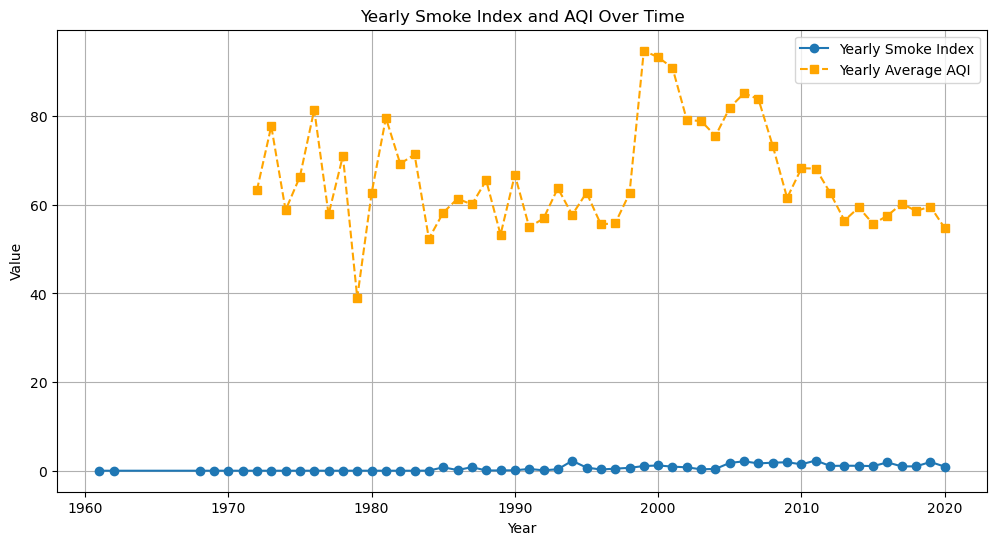

In [51]:
# Merge the AQI data with the smoke index data on the year
# Ensure 'yearly_index_for_aqi' has 'Fire_Year' renamed to 'year' for easy merging
yearly_index_for_aqi = yearly_index_for_aqi.rename(columns={'Fire_Year': 'year'})
merged_data = pd.merge(yearly_index_for_aqi, yearly_avg_max_aqi, left_on='year', right_on='year', how='inner')

# Plot the yearly AQI and smoke index on the same chart
plt.figure(figsize=(12, 6))

# Plot the smoke index
plt.plot(merged_data['year'], merged_data['yearly_smoke_index'], label='Yearly Smoke Index', marker='o', linestyle='-')

# Plot the AQI data
plt.plot(merged_data['year'], merged_data['average_max_aqi'], label='Yearly Average AQI', marker='s', linestyle='--', color='orange')

# Customize the plot
plt.title("Yearly Smoke Index and AQI Over Time")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

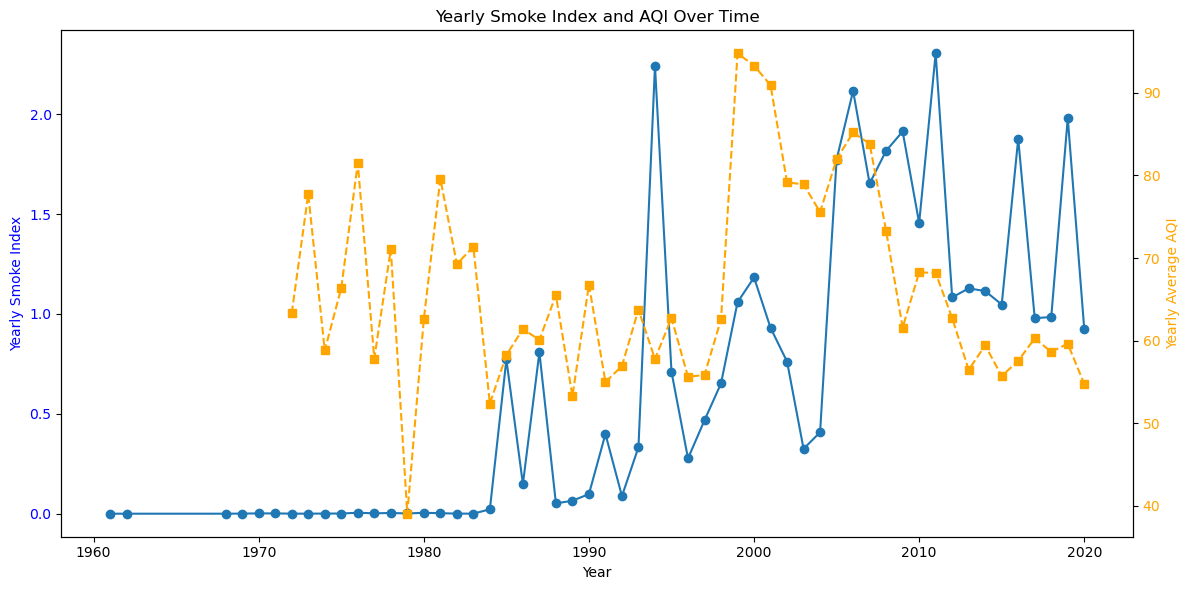

In [52]:
plt.figure(figsize=(12, 6))

# Plot the smoke index on the primary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data['year'], merged_data['yearly_smoke_index'], label='Yearly Smoke Index', marker='o', linestyle='-')
ax1.set_xlabel("Year")
ax1.set_ylabel("Yearly Smoke Index", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for AQI
ax2 = ax1.twinx()
ax2.plot(merged_data['year'], merged_data['average_max_aqi'], label='Yearly Average AQI', marker='s', linestyle='--', color='orange')
ax2.set_ylabel("Yearly Average AQI", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and grid
plt.title("Yearly Smoke Index and AQI Over Time")
fig.tight_layout()  # Adjust layout to prevent overlap

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

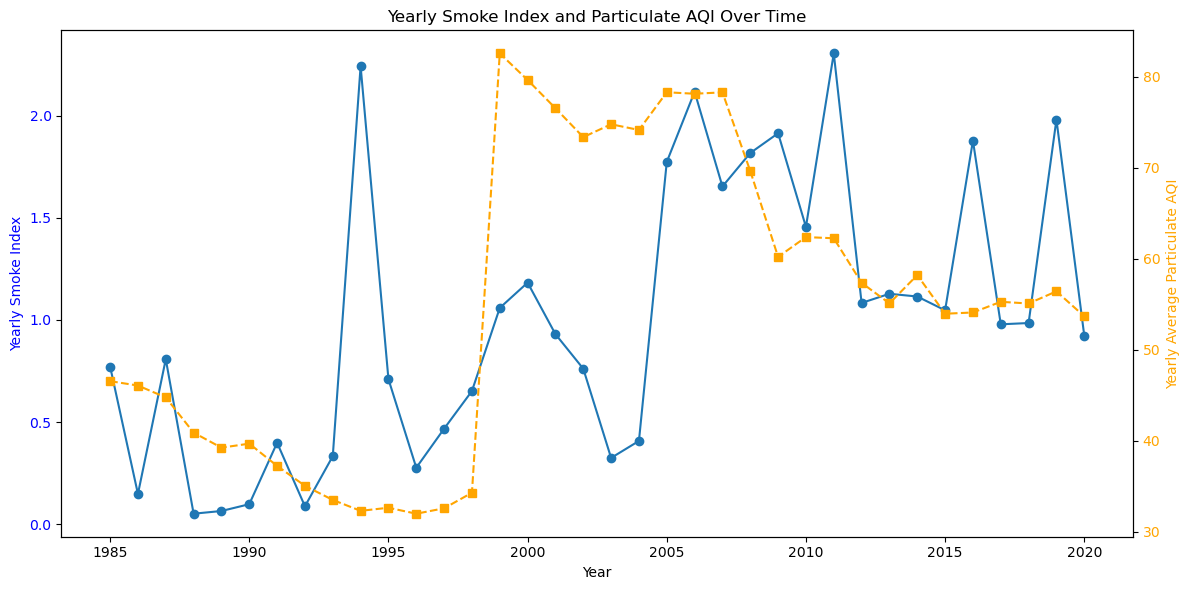

In [53]:
# Extract yearly AQI from the data
# Convert 'date_local' to datetime format
particulate_aqi['date_local'] = pd.to_datetime(particulate_aqi['date_local'])

# Extract the year from 'date_local' and create a 'year' column
particulate_aqi['year'] = particulate_aqi['date_local'].dt.year

# Group by each date to find the maximum AQI for each date
daily_max_aqi = particulate_aqi.groupby('date_local')['aqi'].max().reset_index()

# Extract the year from the 'date_local' column in the daily_max_aqi DataFrame
daily_max_aqi['year'] = daily_max_aqi['date_local'].dt.year

# Group by year and calculate the mean of the daily maximum AQIs for each year
yearly_particulate_aqi = daily_max_aqi.groupby('year')['aqi'].mean().reset_index()
yearly_particulate_aqi.columns = ['year', 'average_max_aqi']

# Merge the AQI data with the smoke index data on the year
# Ensure 'yearly_index_for_aqi' has 'Fire_Year' renamed to 'year' for easy merging
yearly_index_for_aqi = yearly_index_for_aqi.rename(columns={'Fire_Year': 'year'})
merged_data_particulate = pd.merge(yearly_index_for_aqi, yearly_particulate_aqi, left_on='year', right_on='year', how='inner')

plt.figure(figsize=(12, 6))

# Plot the smoke index on the primary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_particulate['year'], merged_data_particulate['yearly_smoke_index'], label='Yearly Smoke Index', marker='o', linestyle='-')
ax1.set_xlabel("Year")
ax1.set_ylabel("Yearly Smoke Index", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for AQI
ax2 = ax1.twinx()
ax2.plot(merged_data_particulate['year'], merged_data_particulate['average_max_aqi'], label='Yearly Average AQI', marker='s', linestyle='--', color='orange')
ax2.set_ylabel("Yearly Average Particulate AQI", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and grid
plt.title("Yearly Smoke Index and Particulate AQI Over Time")
fig.tight_layout()  # Adjust layout to prevent overlap

# Show the plot
plt.show()


### Predicting smoke estimate till 2050

In [73]:
time_series = yearly_index.copy()
time_series = time_series.rename(columns={'Fire_Year': 'year'})
time_series = time_series[time_series['year'] >= 1960 ]
time_series

,year,yearly_smoke_index
35,1960,0.000133
36,1961,0.000117
37,1962,0.000073
38,1963,0.000025
39,1964,0.000048
...,...,...
91,2016,1.877045
92,2017,0.978377
93,2018,0.984609
94,2019,1.980190


ADF Statistic: -0.9394114034484405
p-value: 0.7747168575461096
Critical Value (1%): -3.552928203580539
Critical Value (5%): -2.9147306250000002
Critical Value (10%): -2.595137155612245


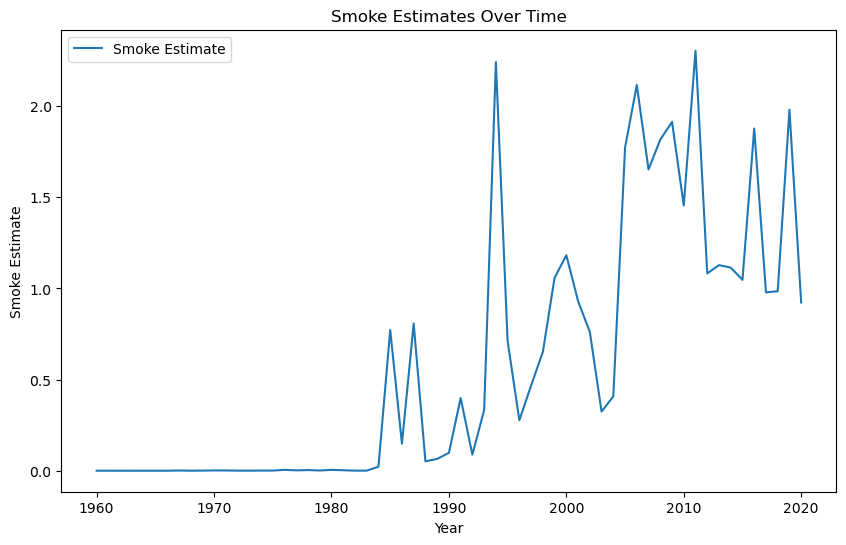

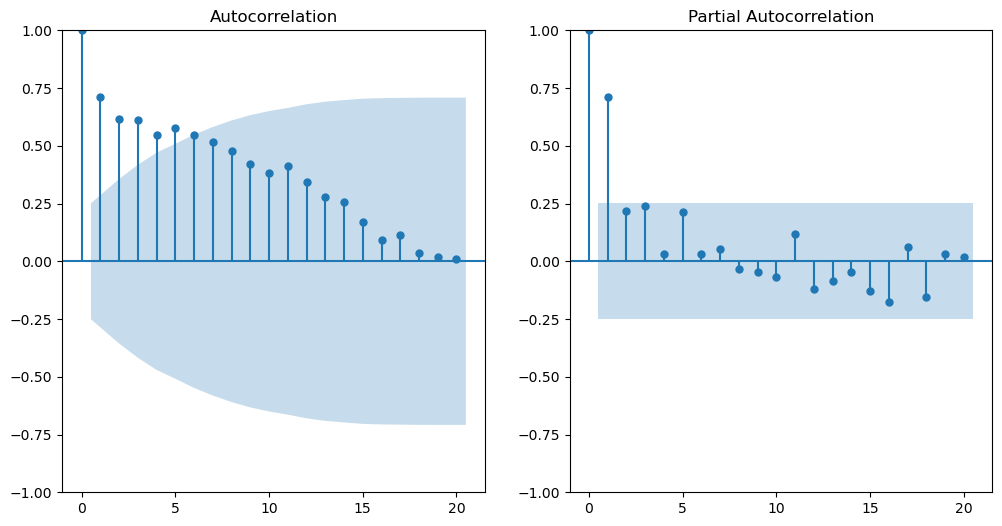

Missing values: 0


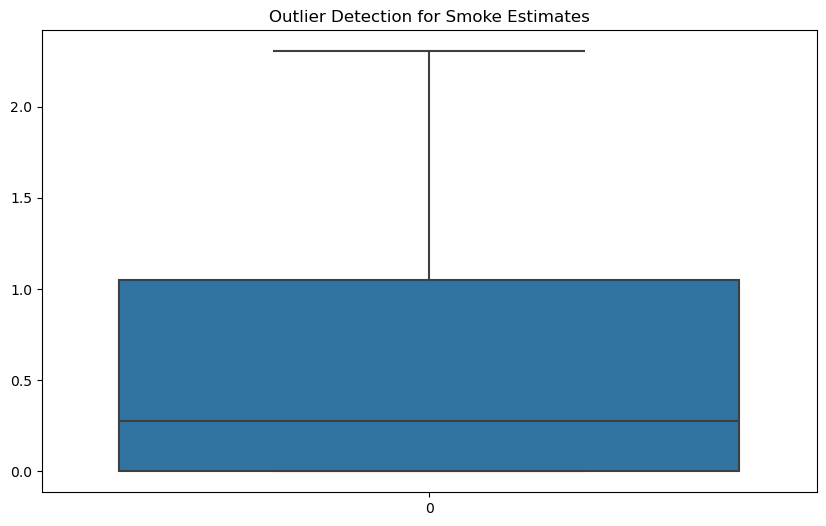

Outliers:
 Empty DataFrame
Columns: [yearly_smoke_index]
Index: []


In [74]:
time_series['year'] = pd.to_datetime(time_series['year'], format='%Y')
time_series.set_index('year', inplace=True)

# 1. Check for Stationarity with ADF Test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
        
adf_test(time_series['yearly_smoke_index'])

# 2. Seasonality and Trends
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series['yearly_smoke_index'], label='Smoke Estimate')
plt.title("Smoke Estimates Over Time")
plt.xlabel("Year")
plt.ylabel("Smoke Estimate")
plt.legend()
plt.show()


# 3. Autocorrelation
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(time_series['yearly_smoke_index'], lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(time_series['yearly_smoke_index'], lags=20, ax=plt.gca())
plt.show()

# 4. Outliers and Missing Values
# Check for missing values
missing_values = time_series['yearly_smoke_index'].isnull().sum()
print("Missing values:", missing_values)

# Detect outliers using boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(time_series['yearly_smoke_index'])
plt.title("Outlier Detection for Smoke Estimates")
plt.show()

# Print outliers based on IQR
Q1 = time_series['yearly_smoke_index'].quantile(0.25)
Q3 = time_series['yearly_smoke_index'].quantile(0.75)
IQR = Q3 - Q1
outliers = time_series[(time_series['yearly_smoke_index'] < (Q1 - 1.5 * IQR)) | (time_series['yearly_smoke_index'] > (Q3 + 1.5 * IQR))]
print("Outliers:\n", outliers)


#### Interpretation of Results

We interpret the results from our tests below:

##### 1. ADF Test (Stationarity)
- **ADF Statistic**: -0.657
- **p-value**: 0.857
- **Critical Values**: At all confidence levels (1%, 5%, and 10%), the test statistic is much higher than the critical values.

**Interpretation**: The high p-value (0.857) suggests that we cannot reject the null hypothesis, which implies that the time series is *non-stationary*. This is consistent with the plot that shows an upward trend in smoke estimates, especially after the 1980s.

To make this series stationary, we may consider differencing the data (e.g., first differencing), or if there is an exponential trend, log-transforming the data before differencing.

##### 2. Seasonality and Trends (Decomposition)
- The decomposition plot shows a clear upward **trend**, especially after 1980, and some periodic fluctuations in the **seasonal** component.
- The **residuals** (bottom panel) seem fairly stable, without major deviations, indicating that most of the variability is captured by the trend and seasonality components.

**Interpretation**: The presence of trend and periodic fluctuations suggests that a model which can handle both trend and seasonality may be appropriate after ensuring stationarity.

##### 3. Autocorrelation and Partial Autocorrelation (ACF and PACF)
- **ACF**: The autocorrelation function shows significant correlation values that gradually decrease, suggesting persistence in the data and supporting the presence of a trend.
- **PACF**: The partial autocorrelation function shows a strong first lag and then decays, which could imply an autoregressive component but also suggests that the data has a long-term dependency structure.

**Interpretation**: This pattern indicates that the data has serial correlation, which is typical of a non-stationary series. 

##### 4. Outliers and Missing Values
- **Missing Values**: There are no missing values, which is good for continuity.
- **Outliers**: The boxplot and the IQR-based detection identified several high values (e.g., in 1994, 2005, 2006, 2008, etc.) that could be considered outliers.

**Interpretation**: These outliers reflect extreme smoke values in specific years. These likely represent true events (e.g., years with significant wildfires), therefore it's best to keep them.


23:45:16 - cmdstanpy - INFO - Chain [1] start processing
23:45:17 - cmdstanpy - INFO - Chain [1] done processing


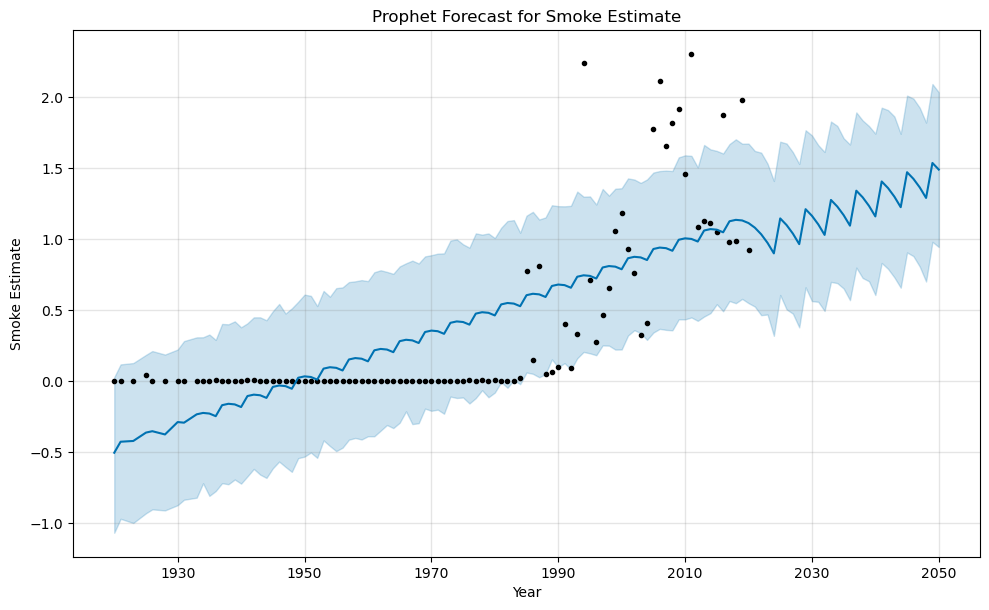

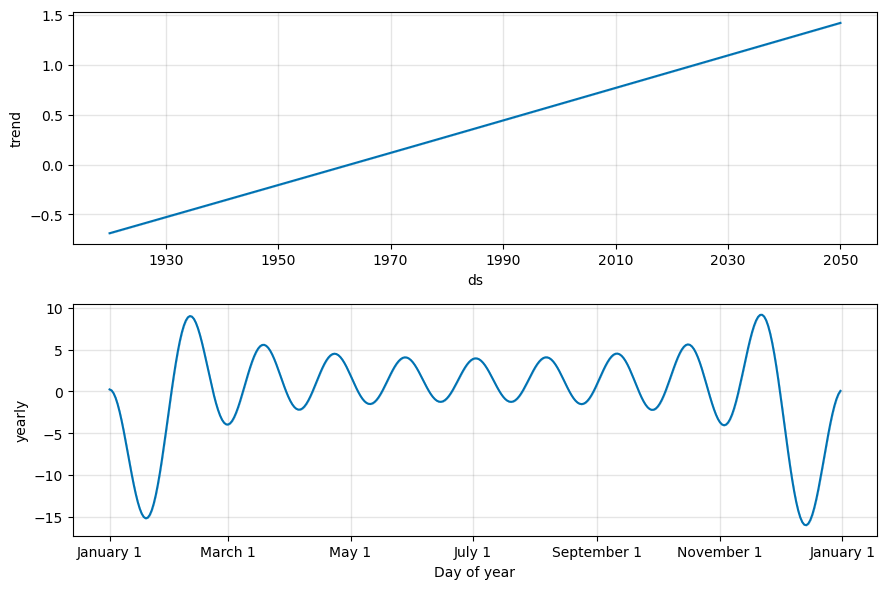

In [67]:
from prophet import Prophet
import pandas as pd

# Prepare the time_series for Prophet
prophet_time_series = time_series.reset_index()  # Reset index to get 'year' as a column
prophet_time_series.columns = ['ds', 'y']  # Prophet requires 'ds' for date and 'y' for the target

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True)
model.fit(prophet_time_series)

# Create a time_seriesFrame with future dates for prediction (up to 2050)
future = model.make_future_dataframe(periods=2050 - prophet_time_series['ds'].dt.year.max(), freq='Y')

# Generate the forecast
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Prophet Forecast for Smoke Estimate")
plt.xlabel("Year")
plt.ylabel("Smoke Estimate")
plt.show()

# Optional: Plot forecast components (trend, yearly seasonality, etc.)
model.plot_components(forecast)
plt.show()


### Visualizations

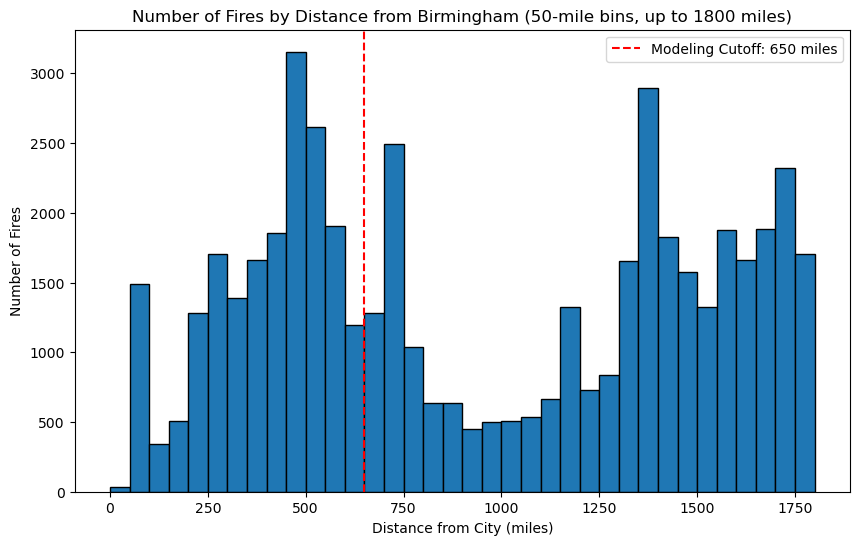

In [36]:
# Read data filtered to 1800 miles
gdf_filtered = gpd.read_file("intermediate-data/gdf_filtered.geojson")

# Convert 'distance_to_city' from meters to miles (1 meter ≈ 0.000621371 miles)
gdf_filtered['distance_to_city_miles'] = gdf_filtered['distance_to_city'] * 0.000621371

# Create bins for every 50-mile interval up to 1800 miles
bins = range(0, 1801, 50)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(gdf_filtered['distance_to_city_miles'], bins=bins, edgecolor='black')
plt.xlabel('Distance from City (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires by Distance from Birmingham (50-mile bins, up to 1800 miles)')

# Step 5: Mark the distance cutoff for modeling work (replace with your specific cutoff)
cutoff_distance = 650  # Example distance cutoff in miles
plt.axvline(cutoff_distance, color='red', linestyle='--', label=f'Modeling Cutoff: {cutoff_distance} miles')
plt.legend()

plt.show()


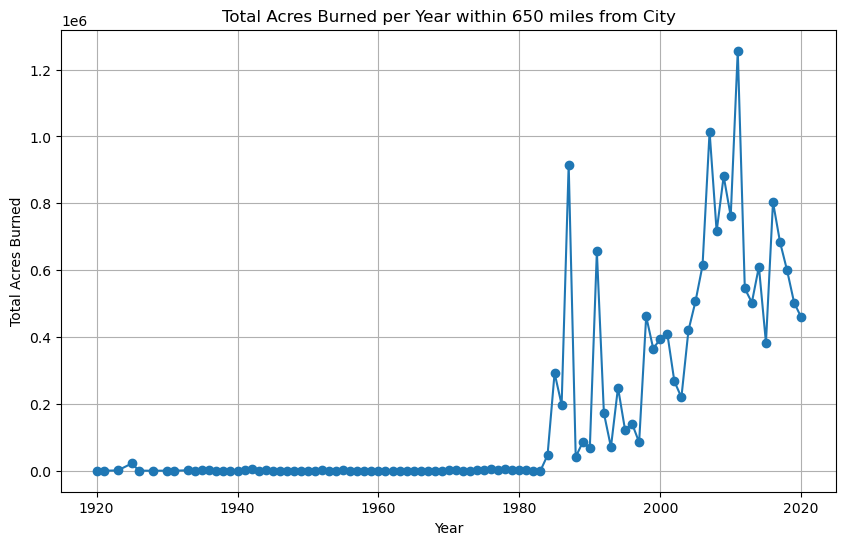

In [39]:
gdf_analysis = gpd.read_file("intermediate-data/gdf_analysis.geojson")

# Group by year and calculate the total acres burned per year
acres_per_year = gdf_analysis.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

# Plotting the time series of total acres burned per year
plt.figure(figsize=(10, 6))
plt.plot(acres_per_year['Fire_Year'], acres_per_year['GIS_Acres'], marker='o')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned per Year within 650 miles from City')
plt.grid(True)
plt.show()